In [1]:
# Libraries for this notebook

import warnings
# Filter out depreciation warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import os
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# ML task 2 - Classify images of art pieces

For this second task, I want to classify images into categories (6). To do this, I want to use the pretrained models from TensorFlow hub. 

As I understood, the MET museums had to gather a large number of people to create their art pieces repository, filling in metadata for each piece. To some extend, this manual work could be envision in a more automatic way. Some information could potentially be collected automatically from images of the art pieces, given proper training data. With this task, I would like to classify a selection of art pieces into 6 classes. 

Personnally, with this task, I also want to test different image feature extractors from the TensorFlow hub. In the fourth course project, I chose early in the project one image feature extractor from two options. Here, I would like to test several options and consciously consider which one might be more adequate for my dataset. 


## Preparation

First, let's import the pre-cleaned dataframe for this task. The dataframe was cleaned and selected in the Jupyter notebook 'project-proposal-ChristelCHAPPUIS.ipynb'. The dataframe has all features but only the image (through the url), classification type and object ID will be used in this task.

After importation, let's create the datasets for training and testing. 

In [2]:
df = pd.read_csv('df_ML2.txt')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 39 columns):
Is Highlight           3243 non-null bool
Object ID              3243 non-null int64
Gallery Number         3243 non-null int64
Department             3243 non-null object
AccessionYear          3243 non-null float64
Culture                3243 non-null object
Artist Role            3243 non-null object
Artist Display Name    3243 non-null object
Artist Nationality     3243 non-null object
Artist Begin Date      3243 non-null float64
Artist End Date        3243 non-null float64
Artist Gender          3243 non-null object
Object Begin Date      3243 non-null int64
Object End Date        3243 non-null int64
Medium                 3243 non-null object
Geography Type         3243 non-null object
Country                3243 non-null object
Classification         3243 non-null object
Tags                   3243 non-null object
Artist Century         3243 non-null float64
Depth          

The target variables for this classification are: 

In [4]:
target_variables = np.sort(df.Classification.unique()).tolist()
target_variables

['Coin', 'Dress', 'Earrings', 'Paintings', 'Stone Sculpture', 'Swords']

Let's create the split between training and testing sets and retrieve images from MET website.

For the train/test split, I decided to have a split of 80% / 20% respectively. To perform the split, I prepare a list of 0s and 1s that respectively represent train and test. When retrieving the xth image, it will go into the train or test folder depending on the value of the xth element of the list. 

There will be exactly 100 images for each class.

In [5]:
# Fix randomness for reproductibility
random.seed(0)
# Fraction of train / test sets
split_size_train = 0.8
split_size_test = round(1-split_size_train,1)
# Number of images per class
samples_per_class = 100

# list to randomly separate train from test image
train_test_order = [0] * int(split_size_train*samples_per_class) + [1] * int(split_size_test*samples_per_class)
random.shuffle(train_test_order)

Below is the extraction of the images from the MET website. It is performed only if the current working directory does not already contain a folder 'images'. 

In [6]:
if os.path.exists('images') == False:
    new_folder = os.getcwd()+'\images'
    try: 
        # Make main folder 'images'
        os.mkdir(new_folder)
        
        # Make subfolders 
        for cat in ['train','test']: # first level: 2 folders
            for var in target_variables: # second level: 6 folders
                os.makedirs(os.path.join('images', cat, var))
        
        # Fill in these subfolders with the images
        selection = []
        for var in target_variables:
            # Restrict the dataframe to the class only
            print(var)
            df_var = df[df['Classification']==var]
    
            # Initiate counts
            cnt = 0
            i = 0
    
            # As long as less than 100 images have not been selected, run this while loop
            while cnt < samples_per_class:
                # Extract url from dataframe
                url = df_var['primaryImageSmall'].iloc[i]
        
                # Make file name folder /images/train OR test/class name/filename
                image_name = str(var) + str(cnt) + '.png'
                image_path = os.path.join('images', str(['train','test'][train_test_order[cnt]]), var, image_name)
        
                # Proceed with the request
                r = requests.get(url)
                if r.status_code == 200:
                    # Open the image file, write down the request content and close file
                    i_f = open(image_path, "wb")
                    i_f.write(r.content)
                    i_f.close()
                    
                    # Open the image, check if the dimension is 3. 
                    img = np.array(Image.open(image_path))
                    if img.ndim == 3: #If True, cnt increases by 1, else the current image will be overwritten with the next image with proper dimension
                        cnt=cnt+1
                        selection.append(df_var.iloc[i].objectID) # keep a trace of the ID selected
                i = i+1
        
    except Exception as e:
        print('Oups, there was an issue with the creation of folders and filling them with images')
        print(e)
    else:
        print('New folders created and filled')
else:
    print('Main image folder already existing')

Main image folder already existing


### Short exploration of images for training

Let's have a look at a selection of images from each class of the train set.

Category: Coin


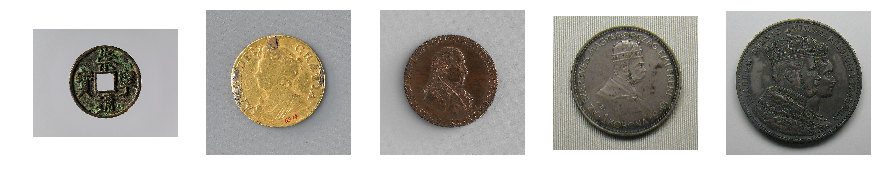

Category: Dress


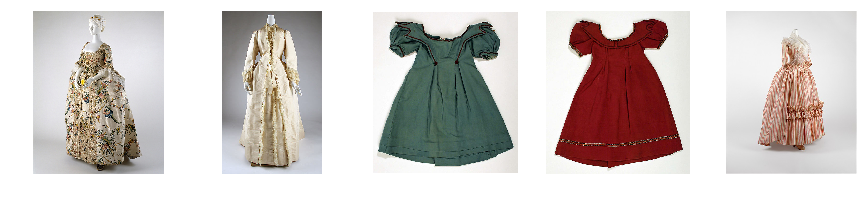

Category: Earrings


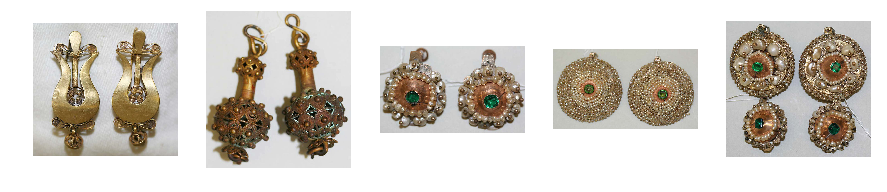

Category: Paintings


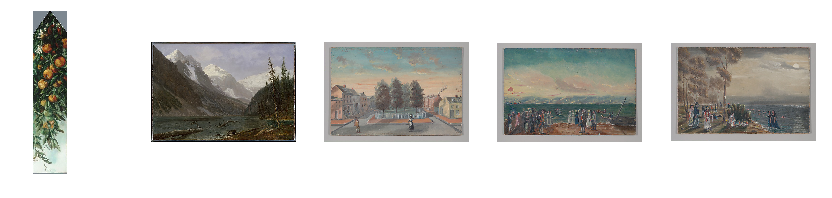

Category: Stone Sculpture


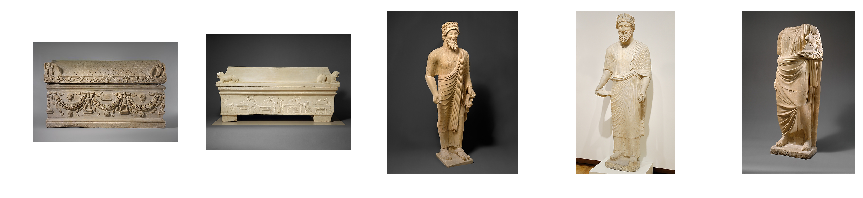

Category: Swords


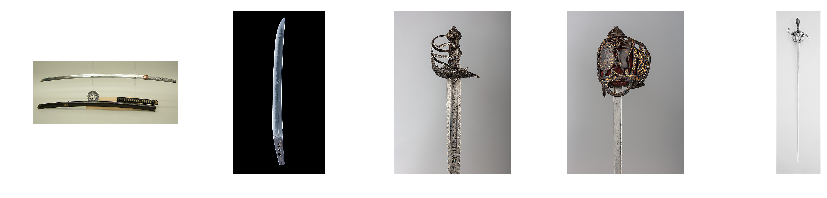

In [7]:
for cat in target_variables:
    print('Category:', cat)
    
    # Make subplot
    fig, ax = plt.subplots(1,5,figsize=(15,3))
    
    for i in np.arange(5):
        # Load the image using pillow
        pillow_img = Image.open(os.path.join('images','train',cat,os.listdir(os.path.join('images','train',cat))[i]))
        
        # Convert into np array
        img = np.array(pillow_img)
        
        # Plot
        ax[i].imshow(img)
        ax[i].axis('off')
        
    plt.show()

## High-level features extractions

A motivation of mine for this task is to see how performant are some available feature extractors on this specific image dataset

I have decided to extract high-level features from the images using four different pretrained models:

- [MobileNet](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/3), 1280 features
- [Inception](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/3), 2048 features
- [ResNet](https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/3), 2048 features
- [Inception ResNet](https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3), 1536 features


### Create general function to extract features

For a cleaner notebook, I have decided to create a function running the feature extractors. This function takes as argument the url for TensorFlow hub, the ImageDataGenerator and the number of features. It returns the features for training, testing as well as the training and testing labels

In [8]:
# Create the image generator, only applying a scaling 0-1. 
img_generator = ImageDataGenerator(rescale=1/255)

In [9]:
def feature_extractor(module_url, img_generator, num_features):
    # Create graph
    img_graph = tf.Graph()
    with img_graph.as_default():
        
        # Download module
        module = hub.Module(module_url)
        height, width = hub.get_expected_image_size(module)
    
        # Train set
        trainset = img_generator.flow_from_directory(os.path.join('images','train'), batch_size=1, target_size=(height, width), shuffle=False)
        # Test set
        testset = img_generator.flow_from_directory(os.path.join('images','test'), batch_size=1, target_size=(height, width), shuffle=False)
        # Class numbers
        print(trainset.class_indices)
        
        # Input placeholder
        input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, height, width, 3])
        
        # Node with the features
        imgs_features = module(input_imgs)
        
        # Collect initializers
        init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
        
    img_graph.finalize()
    
    nb_train = len(trainset.filenames)
    nb_test = len(testset.filenames)
    
    # Create a session
    sess = tf.Session(graph=img_graph)

    # Initialize it
    sess.run(init_op)

    # Extract training features
    train_features = np.empty((0,num_features))
    train_labels = []
    for i in np.arange(nb_train):
        batch_img, batch_label = trainset.next()
        features = sess.run(imgs_features, feed_dict={input_imgs: batch_img})
        train_features = np.append(train_features, features, axis=0)
        train_labels.append(batch_label.argmax())

    train_labels = np.array(train_labels)


    # Extract test features
    test_features = np.empty((0,num_features))
    test_labels = []
    for i in np.arange(nb_test):
        batch_img, batch_label = testset.next()
        features = sess.run(imgs_features, feed_dict={input_imgs: batch_img})
        test_features = np.append(test_features, features, axis=0)
        test_labels.append(batch_label.argmax())

    test_labels = np.array(test_labels)  
    return train_features, train_labels, test_features, test_labels

In [10]:
X_tr_MN, y_tr_MN, X_te_MN, y_te_MN = feature_extractor('https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/1', img_generator, 1280)

Found 480 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
{'Coin': 0, 'Dress': 1, 'Earrings': 2, 'Paintings': 3, 'Stone Sculpture': 4, 'Swords': 5}
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Let's perform some data exploration on the high-level features extracted with Mobilenet v2.

## PCA

Let's try PCA on this first set of features

In [11]:
# Create PCA 
pca = PCA(n_components=None)

# Apply PCA to rescaled data
pca.fit(X_tr_MN)

# Proportion of variance explained
pve = pca.explained_variance_ratio_

With the results of PCA, let's create
- a screen plot with the proportion of variance explained by each feature as well as the cumulative sum of these proportions
- explicit what percentage of the variance is explained by how many components
- the 2d-plot of the features with PCA using the first two components

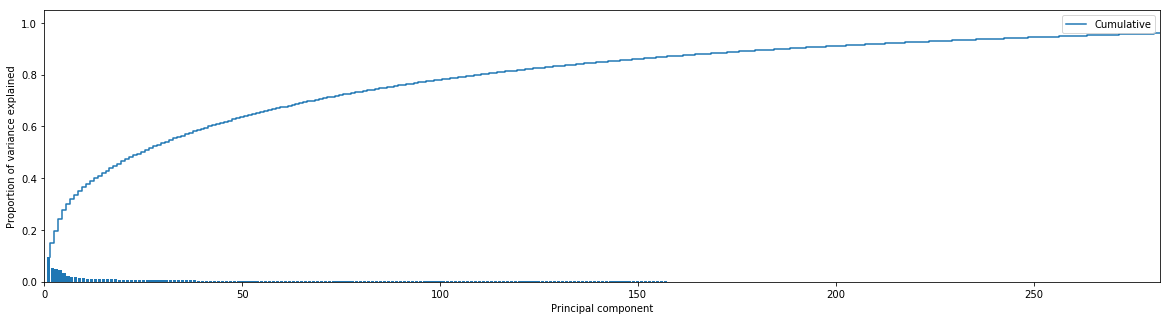

In [12]:
# Create bar plot
fig = plt.figure(figsize=(20,5))
xcor = np.arange(1, len(pve) + 1)
plt.bar(xcor, pve)
plt.xlim(0,282)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(xcor+0.5, pve_cumsum, label='Cumulative')

# Add labels
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.legend()
plt.show()

In [13]:
for i in np.arange(0.1, 1.1, 0.1):
    nb_principal_component = np.size(pve_cumsum) - np.count_nonzero(pve_cumsum>i) + 1
    print('{:.0f}% of the variance is explained by : {} principal components'.format(i*100,nb_principal_component))

10% of the variance is explained by : 2 principal components
20% of the variance is explained by : 4 principal components
30% of the variance is explained by : 6 principal components
40% of the variance is explained by : 14 principal components
50% of the variance is explained by : 25 principal components
60% of the variance is explained by : 42 principal components
70% of the variance is explained by : 68 principal components
80% of the variance is explained by : 110 principal components
90% of the variance is explained by : 187 principal components
100% of the variance is explained by : 481 principal components


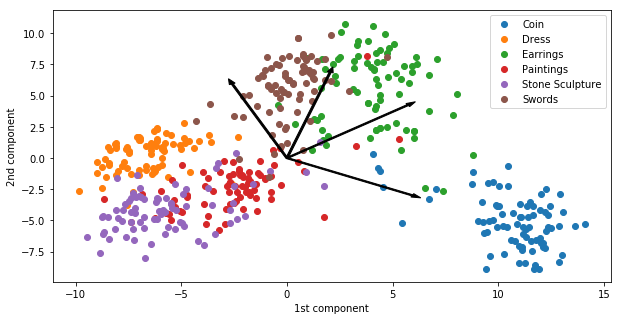

In [14]:
# Let's project data onto the first two components
X_tr_MN_2d = pca.transform(X_tr_MN)[:,0:2]

# Create figure
fig = plt.figure(figsize=(10,5))

for kind in np.arange(len(target_variables)):
    # Image samples of this type
    idx = (y_tr_MN == kind)
    cat = target_variables[kind]

    # Plot their components
    plt.scatter(X_tr_MN_2d[idx, 0], X_tr_MN_2d[idx, 1], label=cat)

# Create a DataFrame with variance and the two principal components
PCA_results = pd.DataFrame({'variance': X_tr_MN.var(axis=0),'1st component': pca.components_[0],'2nd component': pca.components_[1]})
pick1 = PCA_results.sort_values('1st component', ascending=False).iloc[0:2,:].index.tolist()
pick2 = PCA_results.sort_values('2nd component', ascending=False).iloc[0:2,:].index.tolist()

# Plot a few features (selected from the DataFrame above)
for feature in pick1+pick2:
    # Extract the weights
    weight1 = PCA_results.loc[feature, '1st component']*50
    weight2 = PCA_results.loc[feature, '2nd component']*50

    # Plot arrows
    plt.arrow(0, 0, weight1, weight2, color='black', width=0.1)
    
# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

The first two principal components from PCA dimensionality reduction show already some quite defined structure in the data. 

## t-SNE

Let's go a little further by trying out t-SNE on the high-level features directly.

Time to fit-transform with t-SNE on all features: 4.279 s


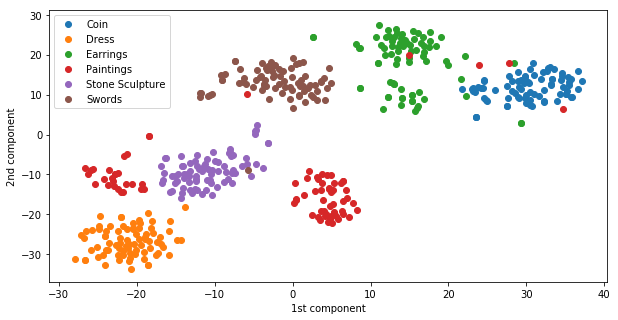

In [15]:
# Initialize timer
time_start = time.time()
# Create t-SNE 
tSNE = TSNE(random_state=0)
# Run t-SNE
X_tr_MN_tSNE = tSNE.fit_transform(X_tr_MN)

print('Time to fit-transform with t-SNE on all features:',round(time.time()-time_start,3), 's')

# Create figure
plt.figure(figsize=(10,5))

for kind in np.arange(len(target_variables)):
    # Image samples of this type
    idx = (y_tr_MN == kind)
    cat = target_variables[kind]

    # Plot their components
    plt.scatter(X_tr_MN_tSNE[idx, 0], X_tr_MN_tSNE[idx, 1], label=cat)
    
# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

According to t-SNE documentation, it is advised to perform a first dimensionality reduction, for example with PCA, thus reducing the number of features to about 50 before performing t-SNE. 

Let's apply this recommendation here. Firstly, the high-level features are reduced to the 50th first PCA principal components. Then, t-SNE is used to further reduce the dimensionality to 2 components that are plotted. 

Time to fit-transform with t-SNE on 50 features from PCA: 3.973 s


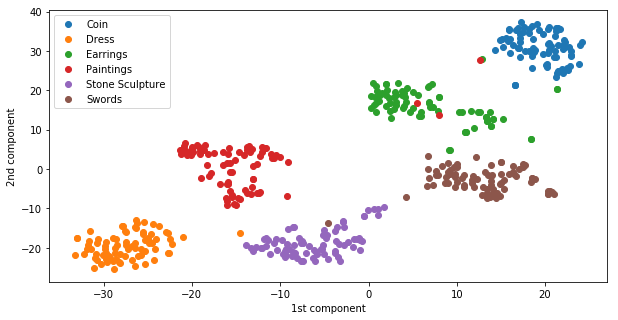

In [16]:
# Initiate timer
time_start = time.time()
# Select 50 components from PCA
X_tr_MN_50d = pca.transform(X_tr_MN)[:,0:50]
# Run t-SNE
X_tr_MN_PCA_tSNE = tSNE.fit_transform(X_tr_MN_50d)

print('Time to fit-transform with t-SNE on 50 features from PCA:',round(time.time()-time_start,3), 's')

# Create figure
fig = plt.figure(figsize=(10,5))

for kind in np.arange(len(target_variables)):
    # Image samples of this type
    idx = (y_tr_MN == kind)
    cat = target_variables[kind]

    # Plot their components
    plt.scatter(X_tr_MN_PCA_tSNE[idx, 0], X_tr_MN_PCA_tSNE[idx, 1], label=cat)
    
# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

Although the first t-SNE already performed well, this last version displays great results. All classes are well separated and only a few datapoints are missgrouped. 

Let's address the class prediction proper now. In order to compare feature extractor, I have decided to use only one type of classifier on top of it, a knn classifier. 

## Classification

### Baseline

For the baseline, I will use the DummyClassifier from sklearn with the strategy 'uniform' as the dataset is absolutely balanced.

In [17]:
dummy_uniform = DummyClassifier(strategy="uniform")
dummy_uniform.fit(None,y_tr_MN)
acc_uniform = dummy_uniform.score(None,y_te_MN)

### K-nearest neighbors

Let's first create the classifier. A cross-validation grid-search will be performed in order to chose the best number of neighbors to consider. 

Here again, I create a function to reuse for each high-level features. It takes as argument train and test sets, both features and target labels. It create a graphs to identify the best n_neighbors parameter, plot images of the wrong classification and outputs a confusion matrix

In [18]:
# Create a knn classifier
knn = KNeighborsClassifier()

# Create a cross-validation object
grid = {'n_neighbors': [1,2,3,5,8,10,15]}
grid_cv = GridSearchCV(knn, grid, cv=5, return_train_score=True)   

In [19]:
def runKNN_gscv(X_tr, y_tr, X_te, y_te):
    # Fit estimator
    grid_cv.fit(X_tr, y_tr)

    # Collect results in a DataFrame
    cv_results = pd.DataFrame(grid_cv.cv_results_)

    # Plot the training and validation curves
    plt.plot(cv_results['param_n_neighbors'], cv_results['mean_train_score'], label='train curve')
    plt.plot(cv_results['param_n_neighbors'], cv_results['mean_test_score'], label='validation curve')
    plt.ylabel('accuracy')
    plt.xlabel('k')
    best_k = cv_results.loc[cv_results.mean_test_score.idxmax(axis=0)].param_n_neighbors
    acc_va = cv_results[cv_results.param_n_neighbors==best_k].mean_test_score.iloc[0]
    plt.scatter(best_k, acc_va, marker='x', c='red', zorder=10)
    plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*acc_va))
    plt.legend()
    plt.show()

    # Test
    y_pred = grid_cv.best_estimator_.predict(X_te)
    acc_te = grid_cv.best_estimator_.score(X_te,y_te)
    y_pred_proba = grid_cv.best_estimator_.predict_proba(X_te)
    print('Accuracy on test set: {:.1f}%'.format(100*acc_te))
    
    # Plot wrong predictions
    if acc_te < 1:
        category = np.nonzero((y_te - y_pred).reshape((6,20)))[0]
        position = np.nonzero((y_te - y_pred).reshape((6,20)))[1]
        wrong_pred_proba = y_pred_proba[np.nonzero((y_te - y_pred)),:][0,:]

        correct_value = y_te[y_te != y_pred]
        wrong_pred = y_pred[y_te != y_pred]

        fig, ax = plt.subplots(1,len(category),figsize=(3*len(category),3))
        cnt = 0
        for wrongclass, pos in zip(category, position):
            cat = target_variables[wrongclass]
            pillow_img = Image.open(os.path.join('images','train',cat,os.listdir(os.path.join('images','train',cat))[pos]))
            img = np.array(pillow_img)
            ax[cnt].imshow(img)
            ax[cnt].axis('off')
            print(target_variables[correct_value[cnt]],', predicted as',target_variables[wrong_pred[cnt]],'with probability: ',wrong_pred_proba[cnt,:])
            ax[cnt].set_title('{}, predicted {}'.format(target_variables[correct_value[cnt]],target_variables[wrong_pred[cnt]]))
            ax[cnt].set
            cnt=cnt+1
        plt.show()

    # Confusion matrix
    matrix = confusion_matrix(y_true=y_te, y_pred=y_pred)
    matrix = pd.DataFrame(confusion_matrix(y_true=y_te_MN, y_pred=y_pred, labels=[0,1,2,3,4,5]), 
                          index=['Coin','Dress','Earrings','Paintings','Stone Sculpture','Swords'], 
                          columns=['Coin','Dress','Earrings','Paintings','Stone Sculpture','Swords'])
    print('Confusion matrix (test set)')
    return acc_te, matrix

### MobileNet v2 results

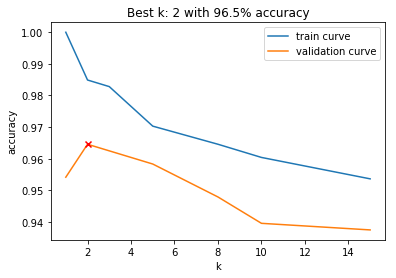

Accuracy on test set: 96.7%
Earrings , predicted as Coin with probability:  [0.5 0.  0.5 0.  0.  0. ]
Earrings , predicted as Coin with probability:  [0.5 0.  0.5 0.  0.  0. ]
Earrings , predicted as Coin with probability:  [0.5 0.  0.5 0.  0.  0. ]
Earrings , predicted as Swords with probability:  [0. 0. 0. 0. 0. 1.]


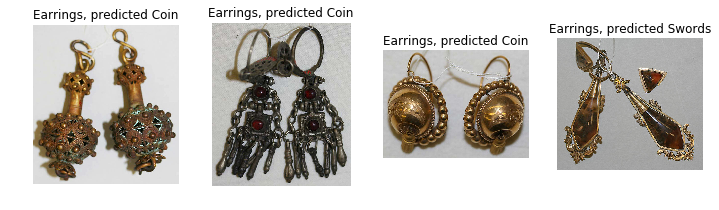

Confusion matrix (test set)


,Coin,Dress,Earrings,Paintings,Stone Sculpture,Swords
Coin,20,0,0,0,0,0
Dress,0,20,0,0,0,0
Earrings,3,0,16,0,0,1
Paintings,0,0,0,20,0,0
Stone Sculpture,0,0,0,0,20,0
Swords,0,0,0,0,0,20


In [20]:
acc_MN, matrix_MN = runKNN_gscv(X_tr_MN, y_tr_MN, X_te_MN, y_te_MN)
matrix_MN

### Inception v3

In [21]:
X_tr_Inc, y_tr_Inc, X_te_Inc, y_te_Inc = feature_extractor('https://tfhub.dev/google/imagenet/inception_v3/feature_vector/3', img_generator, 2048)

Found 480 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
{'Coin': 0, 'Dress': 1, 'Earrings': 2, 'Paintings': 3, 'Stone Sculpture': 4, 'Swords': 5}
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


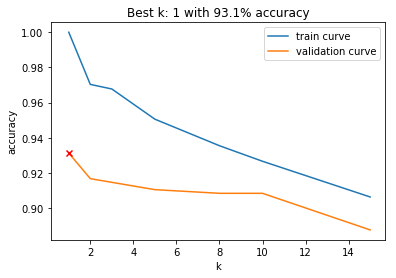

Accuracy on test set: 95.8%
Earrings , predicted as Paintings with probability:  [0. 0. 0. 1. 0. 0.]
Earrings , predicted as Dress with probability:  [0. 1. 0. 0. 0. 0.]
Paintings , predicted as Stone Sculpture with probability:  [0. 0. 0. 0. 1. 0.]
Stone Sculpture , predicted as Dress with probability:  [0. 1. 0. 0. 0. 0.]
Stone Sculpture , predicted as Coin with probability:  [1. 0. 0. 0. 0. 0.]


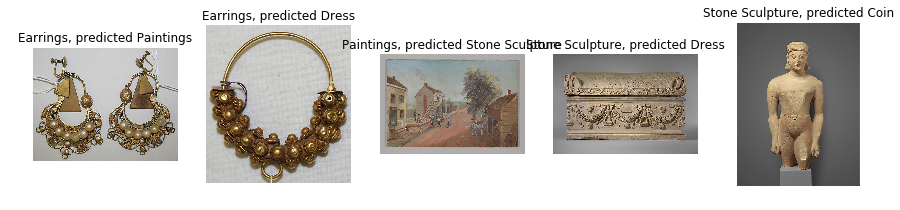

Confusion matrix (test set)


,Coin,Dress,Earrings,Paintings,Stone Sculpture,Swords
Coin,20,0,0,0,0,0
Dress,0,20,0,0,0,0
Earrings,0,1,18,1,0,0
Paintings,0,0,0,19,1,0
Stone Sculpture,1,1,0,0,18,0
Swords,0,0,0,0,0,20


In [22]:
acc_Inc, matrix_Inc = runKNN_gscv(X_tr_Inc, y_tr_Inc, X_te_Inc, y_te_Inc)
matrix_Inc

### ResNet v2

In [23]:
X_tr_RN, y_tr_RN, X_te_RN, y_te_RN = feature_extractor('https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/3', img_generator, 2048)

Found 480 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
{'Coin': 0, 'Dress': 1, 'Earrings': 2, 'Paintings': 3, 'Stone Sculpture': 4, 'Swords': 5}
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


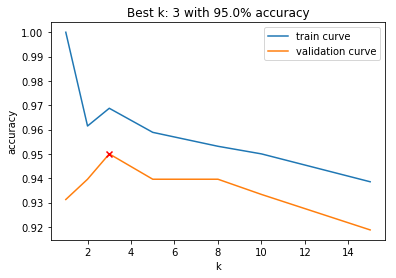

Accuracy on test set: 97.5%
Earrings , predicted as Swords with probability:  [0.         0.         0.33333333 0.         0.         0.66666667]
Paintings , predicted as Coin with probability:  [0.66666667 0.         0.         0.33333333 0.         0.        ]
Swords , predicted as Stone Sculpture with probability:  [0.         0.         0.33333333 0.         0.66666667 0.        ]


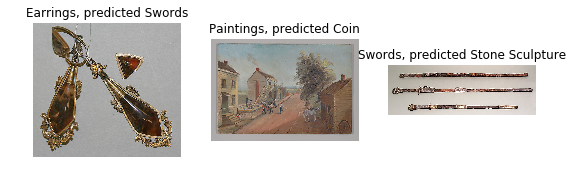

Confusion matrix (test set)


,Coin,Dress,Earrings,Paintings,Stone Sculpture,Swords
Coin,20,0,0,0,0,0
Dress,0,20,0,0,0,0
Earrings,0,0,19,0,0,1
Paintings,1,0,0,19,0,0
Stone Sculpture,0,0,0,0,20,0
Swords,0,0,0,0,1,19


In [24]:
acc_RN, matrix_RN = runKNN_gscv(X_tr_RN, y_tr_RN, X_te_RN, y_te_RN)
matrix_RN

### Inception ResNet v2

In [25]:
X_tr_IncRN, y_tr_IncRN, X_te_IncRN, y_te_IncRN = feature_extractor('https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3', 
                                                                   img_generator, 1536)

Found 480 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
{'Coin': 0, 'Dress': 1, 'Earrings': 2, 'Paintings': 3, 'Stone Sculpture': 4, 'Swords': 5}
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


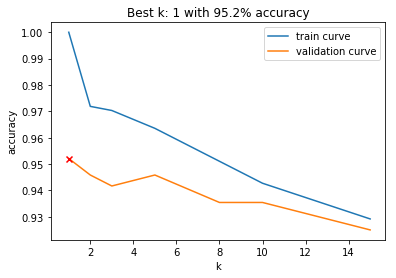

Accuracy on test set: 97.5%
Earrings , predicted as Paintings with probability:  [0. 0. 0. 1. 0. 0.]
Earrings , predicted as Coin with probability:  [1. 0. 0. 0. 0. 0.]
Swords , predicted as Earrings with probability:  [0. 0. 1. 0. 0. 0.]


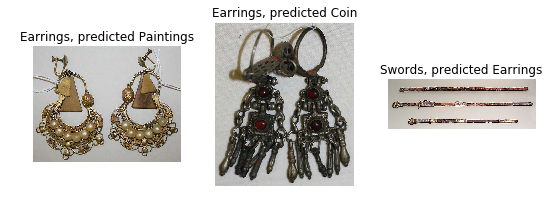

Confusion matrix (test set)


,Coin,Dress,Earrings,Paintings,Stone Sculpture,Swords
Coin,20,0,0,0,0,0
Dress,0,20,0,0,0,0
Earrings,1,0,18,1,0,0
Paintings,0,0,0,20,0,0
Stone Sculpture,0,0,0,0,20,0
Swords,0,0,1,0,0,19


In [26]:
acc_IncRN, matrix_IncRN = runKNN_gscv(X_tr_IncRN, y_tr_IncRN, X_te_IncRN, y_te_IncRN)
matrix_IncRN

## Comparison - final evaluation - discussion

Let's compare the accuracy of each model.

All feature extractors seem to have capture relevant high-level features to be later classified by a knn classifier. 

Considering the size of the dataset and selection performed, I do not think the difference between the models is significant. It might require considering more images across a larger set of classes to differentiate capacities in feature extractors.

Should I have to choose one option, I think I would go with the MobileNet v2 feature extractor in this case. One reason for this choice is a smaller size of the vector of high-level features. It leads to less computational cost for the knn while performing as well as the other feature extractors. 

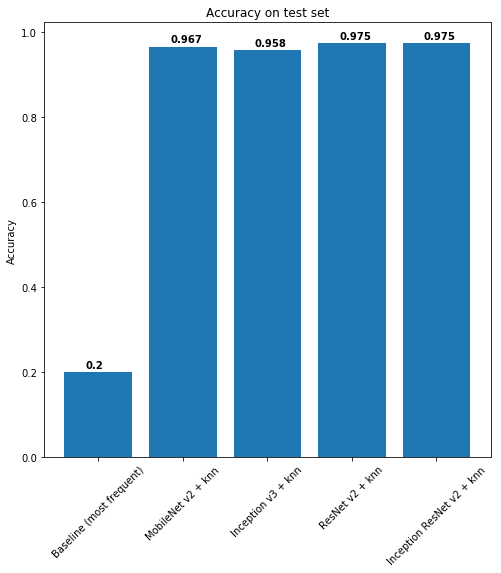

In [27]:
plt.figure(figsize=(8,8))

# Accuracy on test set
y = [acc_uniform,acc_MN,acc_Inc,acc_RN,acc_IncRN]

# Bar chart
plt.bar(x=['Baseline (most frequent)','MobileNet v2 + knn','Inception v3 + knn','ResNet v2 + knn','Inception ResNet v2 + knn'],
          height=y)
plt.ylabel('Accuracy')
plt.title('Accuracy on test set')
plt.xticks(rotation=45)

for i, v in enumerate(y):
    v = round(v,3)
    plt.text(i -0.15, v + 0.01, str(v), color='black', fontweight='bold')
    
plt.show()